# Load data

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K

In [2]:
def read_data(name):
    with open(f'data/labels/{name}') as f:
        labels = f.readlines()
    
    N = int(re.findall(r'\d+', labels[0])[0])
    X = np.load(f'data/keypoints/{name}.npy').reshape((N, 17, 3))
    y = np.zeros(N, dtype=int)
    
    for lab in labels:
        C = re.findall(r'\d:', lab)

        if len(C) == 1:
            C = int(C[0][0])
            idxs = re.findall(r'\d+-\d+', lab)
            for idx in idxs:
                start, stop = idx.split('-')
                y[int(start): int(stop)] = C
    
    return X, y

In [3]:
def normalize_mid_points(X):
    """Calculate middle point between two hips 
         and substract this point from other coordinates
       Returns:
         normalized coords with concatenated mid point
        """
    left_hip, right_hip = 11, 12
    N = X.shape[0]
    mid_points = (X[:, left_hip, :] + X[:, right_hip, :]) / 2
    mp = mid_points.reshape(N, 1, 3)
    x_n = X - mp
    return np.concatenate([x_n, mp], axis=1).reshape(N, 54)

In [4]:
X, y = read_data('id0_jab_1')

In [5]:
X = normalize_mid_points(X)

In [6]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

feature_names = []
for name in list(KEYPOINT_DICT.keys()):
    feature_names.append(name+'-x')
    feature_names.append(name+'-y')
    feature_names.append(name+'-z')
feature_names.append('mid_point-x')
feature_names.append('mid_point-y')
feature_names.append('mid_point-z')

In [7]:
df = pd.DataFrame(data=X, columns=feature_names)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,952.0,-0.209921,0.019107,-0.252051,-0.222763,-0.210596,-0.198513,-0.153114
nose-y,952.0,-0.067366,0.038408,-0.211497,-0.084132,-0.064655,-0.045872,0.043811
nose-z,952.0,-0.118112,0.111870,-0.458663,-0.192553,-0.112386,-0.037717,0.223106
left_eye-x,952.0,-0.220383,0.018510,-0.262138,-0.233261,-0.220656,-0.209054,-0.163357
left_eye-y,952.0,-0.048182,0.042857,-0.205098,-0.067014,-0.043546,-0.024520,0.073572
left_eye-z,952.0,-0.079412,0.125403,-0.464801,-0.167357,-0.072045,0.013288,0.286112
right_eye-x,952.0,-0.220706,0.018492,-0.261916,-0.233370,-0.220739,-0.209082,-0.166680
right_eye-y,952.0,-0.062651,0.038190,-0.208406,-0.079563,-0.059664,-0.039637,0.035410
right_eye-z,952.0,-0.118850,0.108253,-0.479943,-0.192899,-0.110694,-0.042882,0.217545
left_ear-x,952.0,-0.216591,0.015170,-0.253969,-0.226993,-0.216391,-0.206850,-0.174260


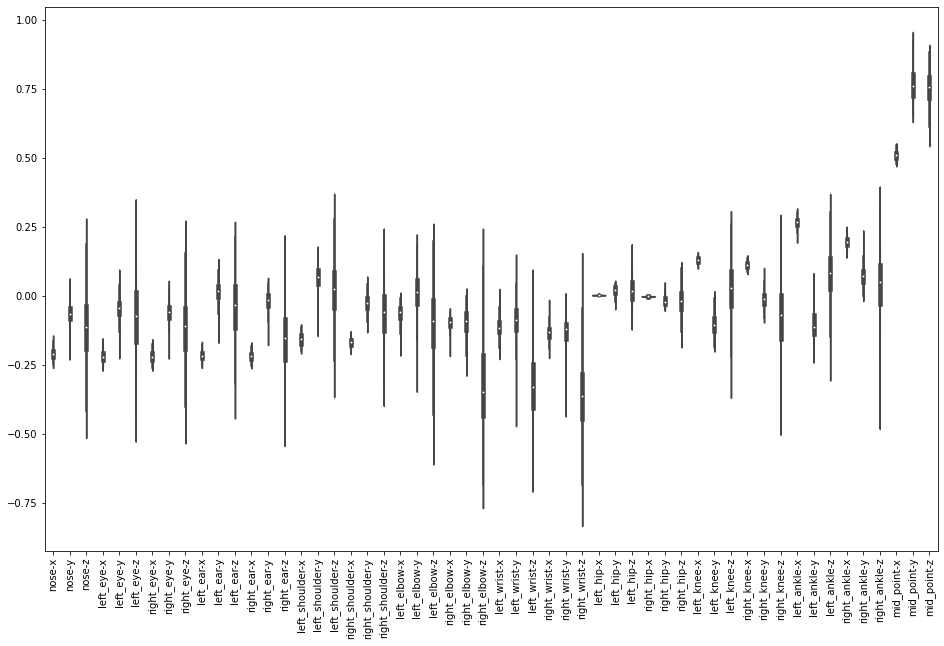

In [9]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [10]:
df['y'] = y

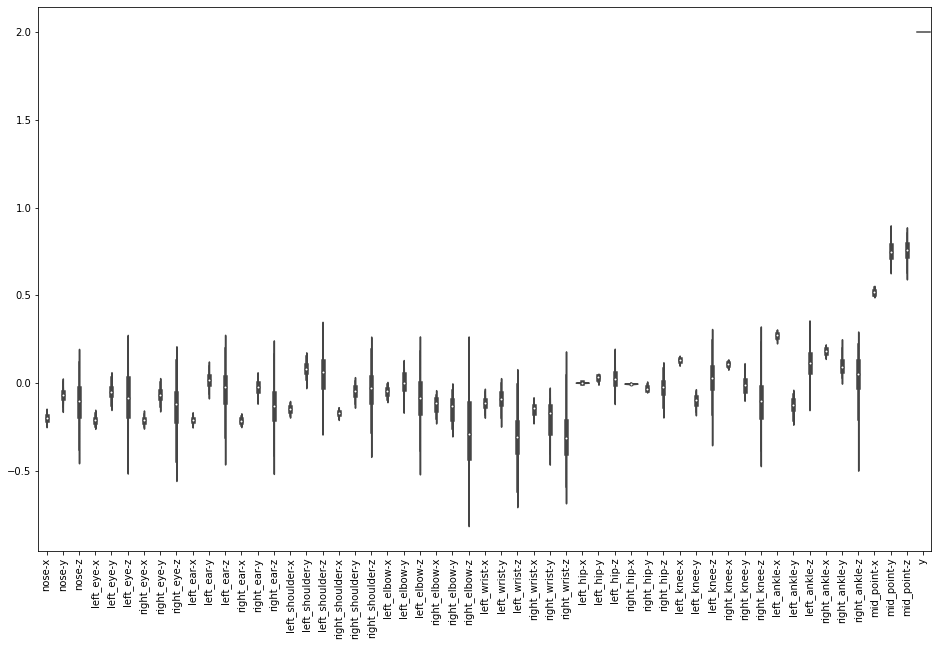

In [11]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df[df.y==2])
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [12]:
X = X.reshape(-1, 8, 54)
y = y.reshape(-1, 8, 1)
X.shape, y.shape

((119, 8, 54), (119, 8, 1))

## LSTM

In [13]:
y = K.utils.to_categorical(y, num_classes=7)
X = tf.constant(X)

2021-10-30 00:51:51.685511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
def build_model(reccur_features=128, dense_features=64, l2=1e-3):
    lstm = K.layers.LSTM(reccur_features,
                         stateful=True,
                         return_sequences=True
                        )
    dense1 = K.layers.Dense(dense_features)
    dense2 = K.layers.Dense(7, activation='sigmoid')

    model = K.Sequential([lstm, dense1, dense2])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = build_model()

In [15]:
model.fit(X, y, batch_size=1, epochs=50)

2021-10-30 00:51:51.766737: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-30 00:51:51.787137: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3912000000 Hz


Epoch 1/50
119/119 [==============================] - 2s 2ms/step - loss: 1.1968 - accuracy: 0.4307
Epoch 2/50
119/119 [==============================] - 0s 2ms/step - loss: 1.0430 - accuracy: 0.4758
Epoch 3/50
119/119 [==============================] - 0s 2ms/step - loss: 1.0146 - accuracy: 0.5536
Epoch 4/50
119/119 [==============================] - 0s 2ms/step - loss: 0.9206 - accuracy: 0.5987
Epoch 5/50
119/119 [==============================] - 0s 2ms/step - loss: 0.8780 - accuracy: 0.6208
Epoch 6/50
119/119 [==============================] - 0s 2ms/step - loss: 0.8302 - accuracy: 0.6523
Epoch 7/50
119/119 [==============================] - 0s 2ms/step - loss: 0.7594 - accuracy: 0.6964
Epoch 8/50
119/119 [==============================] - 0s 2ms/step - loss: 0.7335 - accuracy: 0.7132
Epoch 9/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.7206
Epoch 10/50
119/119 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.7143

In [16]:
x = tf.reshape(X, (1, -1, 54))

In [17]:
y_pred = np.argmax(model(x).numpy(), axis=-1).ravel()

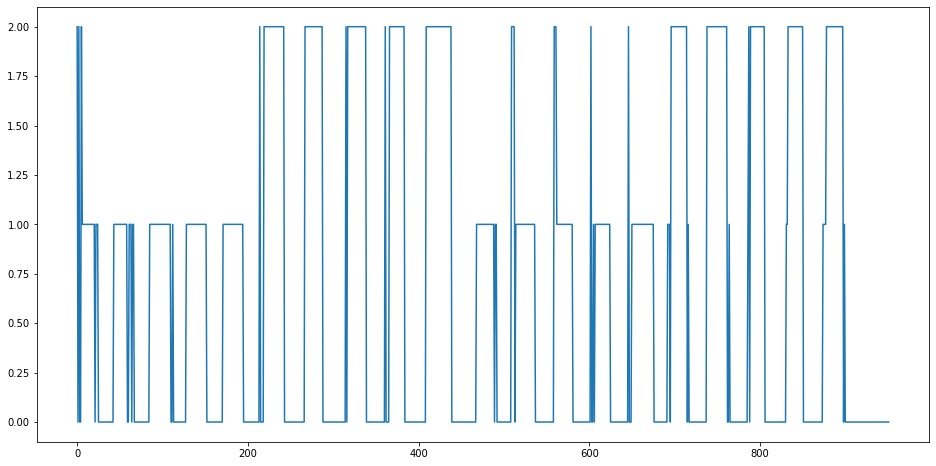

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred)

## Conclusion:
May be we need better feature engineering to overfit model on small dataset.